In [229]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import os

In [230]:
#This mapping should be used for asins list for seller central data pulling also
df_mapping = pd.read_csv("input/Origami Centralised Sales Control Management (CSCM) - SKU Master (1).csv")
# df_mapping = df_mapping[['ASIN','Brand','Category']]
df_mapping = df_mapping[['ASIN','Category']]
df_mapping = df_mapping[~df_mapping['ASIN'].isna()]

#Dashboard
df_mapping_2 = pd.read_excel("input/Dashboard Master.xlsx",sheet_name="Origami - Amazon")

#targets
df_target = pd.read_excel("Target_Origami.xlsx")

In [231]:
#Sales Data - Seller Central

# Path to the folder
folder_path = "data/sales/sc/latest/Origami"

# List all Excel files in the folder
excel_files = [f for f in os.listdir(folder_path) 
               if f.endswith(('.xlsx', '.xls')) and os.path.isfile(os.path.join(folder_path, f))]

# Check if there's at least one Excel file
if excel_files:
    first_file = excel_files[0]
    file_path = os.path.join(folder_path, first_file)
    print(f"Reading Excel file: {file_path}")

    # Read the Excel file into a DataFrame
    df_seller = pd.read_excel(file_path)
#     print(df.head())  # Show first few rows
else:
    print("No Excel files found in the Origami folder.")

Reading Excel file: data/sales/sc/latest/Origami/Origami_A1HIXF7WLP0VDZ_2025-03-01-TO-2025-03-25_seller_central.xlsx


In [232]:
df_seller['Date'] = df_seller['interval'].str[:10]

In [233]:
# Root folder
root_folder = "data/sales/vc/latest/Origami"

# Create a list to hold all DataFrames
all_dfs = []

# Walk through all subdirectories
for dirpath, _, filenames in os.walk(root_folder):
    for filename in filenames:
        if filename.endswith(('.csv')):
            file_path = os.path.join(dirpath, filename)
            print(file_path)
            try:
                df = pd.read_csv(file_path)
                df['__source_file__'] = file_path  # Optional: track source of each row
                all_dfs.append(df)
#                 print(df.shape)
            except Exception as e:
                print(f"Failed to read {file_path}: {e}")

# Combine all DataFrames
if all_dfs:
    df_vendor = pd.concat(all_dfs, ignore_index=True)
    print("Combined DataFrame shape:", combined_df.shape)
#     print(combined_df.head())
else:
    print("No CSV files found in any subfolder of Origami.")


data/sales/vc/latest/Origami/amzn1.vg.8129292/Origami_amzn1.vg.8129292_2025-03-01-TO-2025-03-24.csv
data/sales/vc/latest/Origami/amzn1.vg.7597762/Origami_amzn1.vg.7597762_2025-03-01-TO-2025-03-24.csv
Combined DataFrame shape: (2139, 10)


In [234]:
brand = "Origami"

In [235]:
start_date = '2025-03-01'
end_date = '2025-03-24'

In [236]:
end_date_obj = datetime.strptime(end_date, '%Y-%m-%d')

# Calculate the total days in the end_date's month
if end_date_obj.month == 12:  # December is the last month
    next_month = datetime(end_date_obj.year + 1, 1, 1)
else:
    next_month = datetime(end_date_obj.year, end_date_obj.month + 1, 1)

total_days_in_month = (next_month - datetime(end_date_obj.year, end_date_obj.month, 1)).days

# Days that have already passed in the month
days_passed = end_date_obj.day

In [237]:
# Convert start_date and end_date to datetime for consistency
start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)
end_date_minus_1 = end_date - pd.Timedelta(days=1)

# Assuming df_seller and df_vendor are your DataFrames
# Convert 'Date' and 'startDate' columns to datetime
df_seller['Date'] = pd.to_datetime(df_seller['Date'], errors='coerce')
df_vendor['startDate'] = pd.to_datetime(df_vendor['startDate'], errors='coerce')

# Filter the DataFrames for the given date range
df_seller = df_seller[(df_seller['Date'] <= end_date) & (df_seller['Date'] >= start_date)]
df_vendor = df_vendor[(df_vendor['startDate'] <= end_date) & (df_vendor['startDate'] >= start_date)]


In [238]:
#end date and end date - 1
df_seller_ed = df_seller[df_seller['Date'] == end_date]
df_seller_ed_m1 = df_seller[df_seller['Date'] == end_date_minus_1] #in pipeline this needs to come from last report

#end date and end date - 1
df_vendor_ed = df_vendor[df_vendor['startDate'] == end_date]
df_vendor_ed_m1 = df_vendor[df_vendor['startDate'] == end_date_minus_1] #in pipeline this needs to come from last report

In [239]:
#Streamlit Data prep
df_seller2 = df_seller.groupby(["Date","ASIN"])[['totalSales','orderCount']].sum().reset_index()
df_vendor2 = df_vendor.groupby(["startDate","asin"])[['orderedRevenue','orderedUnits']].sum().reset_index()

df_seller2.columns = ['Date','ASIN', 'GMV', 'Quantity']
df_vendor2.columns = ['Date','ASIN', 'GMV', 'Quantity']

df_sales2 = df_vendor2.merge(df_seller2,on=['Date','ASIN'],how='outer').fillna(0)
df_sales2['GMV'] = df_sales2['GMV_x'] + df_sales2['GMV_y']
df_sales2['Quantity'] = df_sales2['Quantity_x'] + df_sales2['Quantity_y']

df_sales2 = df_sales2[['Date','ASIN', 'GMV', 'Quantity']]

In [240]:
df_seller = df_seller.groupby("ASIN")[['totalSales','orderCount']].sum().reset_index()
df_seller_ed = df_seller_ed.groupby("ASIN")[['totalSales','orderCount']].sum().reset_index()
df_seller_ed_m1 = df_seller_ed_m1.groupby("ASIN")[['totalSales','orderCount']].sum().reset_index()

In [241]:
df_vendor = df_vendor.groupby("asin")[['orderedRevenue','orderedUnits']].sum().reset_index()
df_vendor_ed = df_vendor_ed.groupby("asin")[['orderedRevenue','orderedUnits']].sum().reset_index()
df_vendor_ed_m1 = df_vendor_ed_m1.groupby("asin")[['orderedRevenue','orderedUnits']].sum().reset_index()

In [242]:
df_seller.columns = ['ASIN', 'GMV', 'Quantity']
df_vendor.columns = ['ASIN', 'GMV', 'Quantity']

df_seller_ed.columns = ['ASIN', 'GMV', 'Quantity']
df_vendor_ed.columns = ['ASIN', 'GMV', 'Quantity']

df_seller_ed_m1.columns = ['ASIN', 'GMV', 'Quantity']
df_vendor_ed_m1.columns = ['ASIN', 'GMV', 'Quantity']

In [243]:
df_sales = df_vendor.merge(df_seller,on='ASIN',how='outer').fillna(0)
df_sales['GMV'] = df_sales['GMV_x'] + df_sales['GMV_y']
df_sales['Quantity'] = df_sales['Quantity_x'] + df_sales['Quantity_y']

df_sales_ed = df_vendor_ed.merge(df_seller_ed,on='ASIN',how='outer').fillna(0)
df_sales_ed['GMV'] = df_sales_ed['GMV_x'] + df_sales_ed['GMV_y']
df_sales_ed['Quantity'] = df_sales_ed['Quantity_x'] + df_sales_ed['Quantity_y']

df_sales_ed_m1 = df_vendor_ed_m1.merge(df_seller_ed_m1,on='ASIN',how='outer').fillna(0)
df_sales_ed_m1['GMV'] = df_sales_ed_m1['GMV_x'] + df_sales_ed_m1['GMV_y']
df_sales_ed_m1['Quantity'] = df_sales_ed_m1['Quantity_x'] + df_sales_ed_m1['Quantity_y']

In [244]:
df_sales = df_sales[['ASIN', 'GMV', 'Quantity']]
df_sales_ed = df_sales_ed[['ASIN', 'GMV', 'Quantity']]
df_sales_ed_m1 = df_sales_ed_m1[['ASIN', 'GMV', 'Quantity']]

In [245]:
#should be zero
set(df_vendor['ASIN']) - set(df_mapping['ASIN'])

set()

In [246]:
#should be zero
set(df_seller['ASIN']) - set(df_mapping['ASIN'])

set()

In [247]:
#should be zero
set(df_mapping['ASIN']) - set(df_seller['ASIN'])

{'-', 'B0D83BG8Z9/ B0DF528DX8'}

In [248]:
#should not have duplicates / 1-1 mapping
print(df_mapping.duplicated(subset=['ASIN']).sum())
df_mapping = df_mapping.drop_duplicates(subset=['ASIN'])
print(df_mapping.duplicated(subset=['ASIN']).sum())

251
0


In [249]:
df_sales = df_sales.merge(df_mapping,on='ASIN',how='left')
df_sales_ed = df_sales_ed.merge(df_mapping,on='ASIN',how='left')
df_sales_ed_m1 = df_sales_ed_m1.merge(df_mapping,on='ASIN',how='left')

In [250]:
df_sales = df_sales.groupby('Category')[['GMV','Quantity']].sum().reset_index()
df_sales_ed = df_sales_ed.groupby('Category')[['GMV','Quantity']].sum().reset_index()
df_sales_ed_m1 = df_sales_ed_m1.groupby('Category')[['GMV','Quantity']].sum().reset_index()

In [251]:
#Streamlit Data prep

df_sales2 = df_sales2.merge(df_mapping,on='ASIN',how='left')
df_sales2 = df_sales2.groupby(['Date','Category'])[['GMV','Quantity']].sum().reset_index()

df_sales2 = df_sales2.merge(
    df_target[['Category','GMV']], 
    on='Category', 
    how='left', 
    suffixes=('', '_target')
)

# Now create the "Targeted_GMV" by applying the fraction of the current day
# over the total days in the month for that Date.
df_sales2['GMV_target'] = df_sales2['GMV_target'].fillna(0).astype("int64")

# 4) Calculate fraction of month
fraction_of_month = df_sales2['Date'].dt.day / df_sales2['Date'].dt.days_in_month

# 5) Create "Targeted_GMV"
df_sales2['Targeted_GMV'] = df_sales2['GMV_target'] * fraction_of_month


In [252]:
df_sales2['Targeted_GMV'] = df_sales2['Targeted_GMV'].round(2).astype(float)


In [253]:
import pandas as pd
import numpy as np

df_sales2['Date'] = pd.to_datetime(df_sales2['Date'])

extended_dfs = []

# Get unique categories:
categories = df_sales2['Category'].unique()

for cat in categories:
    # Subset for this Category:
    sub = df_sales2[df_sales2['Category'] == cat].copy()

    # Identify the month we're dealing with (assuming one month per category).
    # For example, if everything is in January 2025:
    #   - get the earliest date and replace day=1 to find month start
    month_start = sub['Date'].min().replace(day=1)
    #   - find the last day of that month
    month_end = month_start + pd.offsets.MonthEnd(0)

    # Create the full daily date range for that month
    all_days = pd.date_range(start=month_start, end=month_end, freq='D')

    # Reindex the sub-DataFrame onto the full date range
    sub = (
        sub.set_index('Date')
           .reindex(all_days)         # daily row for each day in that month
           .rename_axis('Date')       # name the index "Date"
           .reset_index()
    )

    # Insert Category column
    sub['Category'] = cat

    #--- DO NOT fill GMV with 0; we want to keep extended days as NaN ---
    # sub['GMV']      = sub['GMV'].fillna(0)  # <-- We *do not* do this!
    # sub['Quantity'] = sub['Quantity'].fillna(0)

    # Instead, only fill monthly GMV_target forward (and back if needed).
    # That way every row in the month has the same monthly target.
    sub['GMV_target'] = sub['GMV_target'].ffill().bfill().fillna(0)

    # Compute the fraction of the month for each day
    sub['fraction_of_month'] = sub['Date'].dt.day / sub['Date'].dt.days_in_month

    # Daily targeted GMV
    sub['Targeted_GMV'] = sub['GMV_target'] * sub['fraction_of_month']

    # For days after the last actual sale date, we want GMV and Quantity = NaN
    # so that the cumulative GMV for those days is also NaN
    max_actual_date = df_sales2.loc[df_sales2['Category'] == cat, 'Date'].max()
    sub.loc[sub['Date'] > max_actual_date, ['GMV','Quantity']] = np.nan

    # Now compute the Cumulative GMV for the days that do have data
    # By default, if GMV is NaN for a row, cumsum() will also be NaN from that row onward
    # (meaning "no data" for extended days).
    sub['Cumulative_GMV'] = sub['GMV'].cumsum()

    # Similarly, if you want to track cumulative Targeted_GMV (even for future days),
    # you could do:
    sub['Cumulative_Targeted_GMV'] = sub['Targeted_GMV'].cumsum()

    extended_dfs.append(sub)

# Concatenate everything
df_extended = pd.concat(extended_dfs, ignore_index=True)

# Now df_extended has:
#  - Rows for every day of the month for each Category
#  - GMV as NaN on days that are "extended"
#  - A daily Targeted_GMV for each day
#  - 'Cumulative_GMV' that stops after the last actual day (becomes NaN)
#  - 'Cumulative_Targeted_GMV' is computed for all days


In [254]:
df_extended['Targeted_GMV'] = df_extended['Targeted_GMV'].round(2).astype(float)
df_extended['Cumulative_Targeted_GMV'] = df_extended['Cumulative_Targeted_GMV'].round(2).astype(float)


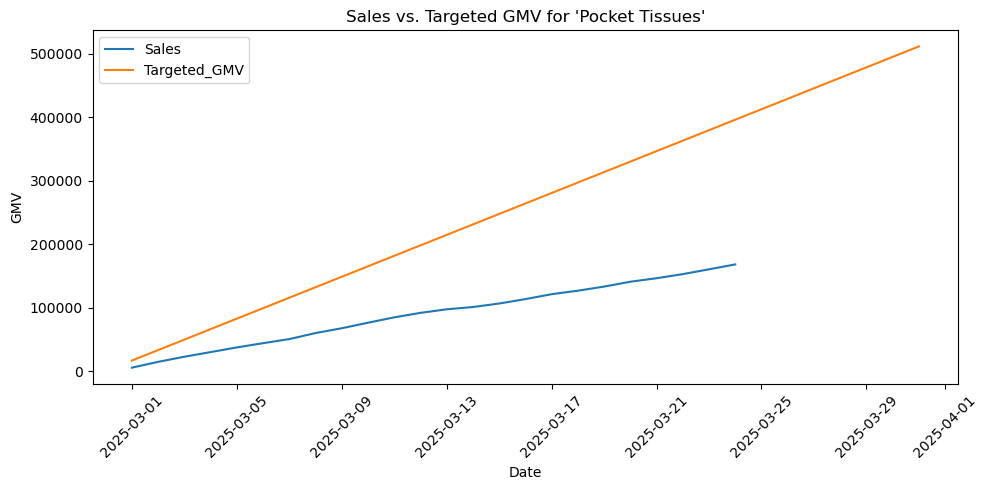

In [255]:
import matplotlib.pyplot as plt

# 1) Filter df_extended for the Category you want
cat = "Pocket Tissues"  # <-- Example category name
sub = df_extended[df_extended['Category'] == cat].copy()

# 2) Sort by Date to ensure the lines plot in chronological order
sub.sort_values(by='Date', inplace=True)

# 3) Plot
plt.figure(figsize=(10, 5))
plt.plot(sub['Date'], sub['Cumulative_GMV'], label='Sales')
plt.plot(sub['Date'], sub['Targeted_GMV'], label='Targeted_GMV')

# 4) Tidy up
plt.title(f"Sales vs. Targeted GMV for '{cat}'")
plt.xlabel("Date")
plt.ylabel("GMV")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [256]:
df_extended['Brand'] = brand
df_extended['Platform'] = "Amazon"
df_extended = df_extended[['Date','Brand','Platform' ,'Category', 'GMV', 'Targeted_GMV', 'Cumulative_GMV']]

In [257]:
df_extended.head()

,Date,Brand,Platform,Category,GMV,Targeted_GMV,Cumulative_GMV
0,2025-03-01,Origami,Amazon,Aluminium Foil,44255.52,42287.16,44255.52
1,2025-03-02,Origami,Amazon,Aluminium Foil,56788.69,84574.32,101044.21
2,2025-03-03,Origami,Amazon,Aluminium Foil,48102.24,126861.48,149146.45
3,2025-03-04,Origami,Amazon,Aluminium Foil,38855.97,169148.65,188002.42
4,2025-03-05,Origami,Amazon,Aluminium Foil,46072.00,211435.81,234074.42


In [258]:
df_extended.to_excel(brand+"_sales_amz.xlsx")


In [259]:
df_output = df_target.merge(df_sales,on='Category',how='left')

In [260]:
df_output.columns = ['Category', 'GMV_Target', 'Quantity_Target', 'ASP', 'GMV_MTD', 'Quantity_MTD']

In [261]:
df_output['GMV_Target'] = df_output['GMV_Target'].astype("float")

In [262]:
df_sales_ed.columns = ['Category', 'GMV_'+str(end_date)[:10], 'Quantity_'+str(end_date)[:10]]
df_sales_ed_m1.columns = ['Category', 'GMV_'+str(end_date_minus_1)[:10], 'Quantity_'+str(end_date_minus_1)[:10]]

In [263]:
df_output = df_output.merge(df_sales_ed,on='Category',how='left')
df_output = df_output.merge(df_sales_ed_m1,on='Category',how='left')

In [264]:
df_output = df_output.fillna(0)

In [265]:
df_output['Attainment%_MTD'] = (df_output['GMV_MTD']/df_output['GMV_Target'])*100

In [266]:
df_output['Attainment%_Forecast'] = df_output['Attainment%_MTD']*(total_days_in_month/days_passed)
df_output['GMV_Forecast'] = df_output['GMV_MTD']*(total_days_in_month/days_passed)

In [267]:
df_output[['Attainment%_MTD','Attainment%_Forecast','GMV_Target','GMV_Forecast','GMV_MTD','GMV_'+str(end_date)[:10],'GMV_'+str(end_date_minus_1)[:10]]] = df_output[['Attainment%_MTD','Attainment%_Forecast','GMV_Target','GMV_Forecast','GMV_MTD','GMV_'+str(end_date)[:10],'GMV_'+str(end_date_minus_1)[:10]]].round(0)

In [268]:
df_report = df_output[['Category','Attainment%_MTD','Attainment%_Forecast','GMV_Target','GMV_Forecast','GMV_MTD','GMV_'+str(end_date)[:10],'GMV_'+str(end_date_minus_1)[:10]]]

In [269]:
df_report['Comparative difference'] = ((df_report['GMV_'+str(end_date)[:10]] - df_report['GMV_'+str(end_date_minus_1)[:10]]) / df_report['GMV_'+str(end_date_minus_1)[:10]]) * 100

/var/folders/jb/jckdq3kd0lz19pvvlchblf400000gn/T/ipykernel_45900/978419422.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_report['Comparative difference'] = ((df_report['GMV_'+str(end_date)[:10]] - df_report['GMV_'+str(end_date_minus_1)[:10]]) / df_report['GMV_'+str(end_date_minus_1)[:10]]) * 100


In [270]:
df_degrowth = df_report[['Category','Comparative difference','GMV_'+str(end_date)[:10],'GMV_'+str(end_date_minus_1)[:10]]]
df_growth = df_report[['Category','Comparative difference','GMV_'+str(end_date)[:10],'GMV_'+str(end_date_minus_1)[:10]]]

In [271]:
df_degrowth['Absolute difference'] = (df_degrowth['GMV_'+str(end_date)[:10]] - df_degrowth['GMV_'+str(end_date_minus_1)[:10]])
df_growth['Absolute difference'] = (df_growth['GMV_'+str(end_date)[:10]] - df_growth['GMV_'+str(end_date_minus_1)[:10]])

/var/folders/jb/jckdq3kd0lz19pvvlchblf400000gn/T/ipykernel_45900/3499501194.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_degrowth['Absolute difference'] = (df_degrowth['GMV_'+str(end_date)[:10]] - df_degrowth['GMV_'+str(end_date_minus_1)[:10]])
/var/folders/jb/jckdq3kd0lz19pvvlchblf400000gn/T/ipykernel_45900/3499501194.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_growth['Absolute difference'] = (df_growth['GMV_'+str(end_date)[:10]] - df_growth['GMV_'+str(end_date_minus_1)[:10]])


In [272]:
df_degrowth = df_degrowth.nsmallest(4, 'Absolute difference')[['Category','Comparative difference']]
df_growth = df_growth.nlargest(4, 'Absolute difference')[['Category','Comparative difference']]

In [273]:
df_degrowth.columns = ['De-Growing Categories','De-Growth %']
df_growth.columns = ['Growing Categories','Growth %']

In [274]:
# # Save to Excel with respective tabs
with pd.ExcelWriter(brand+' Daily Sales Report - Amazon Summary.xlsx') as writer:
    df_report.to_excel(writer, sheet_name='Amazon Original', index=False)
    df_growth.to_excel(writer, sheet_name='Amazon Summary - Growing Categories', index=False)
    df_degrowth.to_excel(writer, sheet_name='Amazon Summary - De-Growing Categories', index=False)



/Users/alpeshsaharia/anaconda3/lib/python3.11/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


In [275]:
df_report[:0]

,Category,Attainment%_MTD,Attainment%_Forecast,GMV_Target,GMV_Forecast,GMV_MTD,GMV_2025-03-24,GMV_2025-03-23,Comparative difference


In [276]:
df_growth

,Growing Categories,Growth %
0,Toilet Tissue Rolls,9.119638
2,Plain Napkins,22.112692
25,Tissue Paper Dispenser,1904.142012
7,Paper Plates,38.801262


In [227]:
df_degrowth

,De-Growing Categories,De-Growth %
4,Non-Woven Kitchen Towel Rolls,-11.240725
1,Kitchen Towel Rolls,-15.165389
3,Box Facial Tissues,-11.562070
6,Box Facial Tissues (Soft),-21.935880
